In [1]:
import torch
from torch import nn
import torch.functional as F
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.latent_dim = 5
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU()
        )
        
        self.mu = nn.Sequential(
            nn.Linear(512, self.latent_dim)
        )
        
        self.sigma = nn.Sequential(
            nn.Linear(512, self.latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28)
        )
        
    
    def forward(self, x):
        x = torch.reshape(x, (-1, 28*28))
        t = self.encoder(x)
        mu, sigma = self.mu(t), self.sigma(t)
        noise = torch.randn_like(mu)
        
        sample = mu + noise*torch.exp(0.5*sigma)
        generated = self.decoder(sample)
        generated = torch.sigmoid(torch.reshape(generated, (-1, 1, 28, 28)))
        return mu, sigma, generated
    
    def sample(self):
        noise = torch.randn(1, self.latent_dim).cuda()
        generated = self.decoder(noise)
        generated = torch.sigmoid(torch.reshape(generated, (-1, 1, 28, 28)))
        return generated

In [22]:
transform = transforms.Compose([transforms.ToTensor()])

training_set = datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = datasets.MNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=2)

In [23]:
def get_digit_samples(data_loader):
    samples = {i: None for i in range(10)}
    found = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data
        for j in range(inputs.shape[0]):
            if samples[labels[j].item()] == None:
                samples[labels[j].item()] = inputs[j]
                found += 1
            
        if found >= 10:
            break
    return samples

In [24]:
digit_samples = get_digit_samples(training_loader)

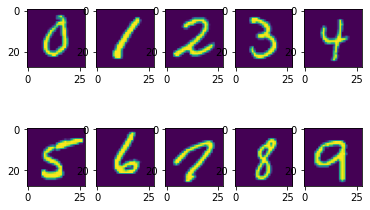

In [25]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    ax[i//5][i%5].imshow(digit_samples[i].squeeze().numpy())
plt.show()

In [26]:
model = VAE().to(device)

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [28]:
def train_one_epoch(epoch_index, tb_writer):
    train_loss = []
    running_loss, running_recons_loss, running_regular_loss = 0., 0., 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]
        # print(inputs, inputs.mean())
        optimizer.zero_grad()
        mu, sigma, generated = model(inputs)
        
        reconstruction_loss = ((generated - inputs)**2).sum() / batch_size
        regularization_loss = (-0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())) / batch_size
        
        loss =  reconstruction_loss + regularization_loss
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_recons_loss += reconstruction_loss.item()
        running_regular_loss += regularization_loss.item()
        train_loss.append(loss.item())
        
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            last_recons_loss = running_recons_loss / 100
            last_regular_loss = running_regular_loss / 100
            print('  batch {} loss: {} recons_loss: {}, regular_loss: {}'.format(i + 1, last_loss, last_recons_loss, last_regular_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss, running_recons_loss, running_regular_loss = 0., 0., 0.

    return last_loss, train_loss

EPOCH 1:


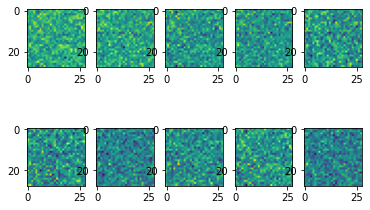

  batch 100 loss: 108.8510863494873 recons_loss: 102.91681579589844, regular_loss: 5.934270369149744
  batch 200 loss: 65.84919914245606 recons_loss: 59.19450752258301, regular_loss: 6.654691319465638
  batch 300 loss: 61.08552547454834 recons_loss: 56.15297271728516, regular_loss: 4.932552869319916
  batch 400 loss: 58.64701789855957 recons_loss: 54.63415897369385, regular_loss: 4.012859036922455
  batch 500 loss: 56.48956729888916 recons_loss: 52.68715518951416, regular_loss: 3.802412197589874
  batch 600 loss: 52.301454048156735 recons_loss: 48.17339153289795, regular_loss: 4.1280625486373905
  batch 700 loss: 50.15263973236084 recons_loss: 45.495309371948245, regular_loss: 4.657329969406128
  batch 800 loss: 47.74924343109131 recons_loss: 42.6498543548584, regular_loss: 5.099389023780823
  batch 900 loss: 45.80988594055176 recons_loss: 40.50692218780517, regular_loss: 5.30296371459961
  batch 1000 loss: 44.42348190307617 recons_loss: 38.92119743347168, regular_loss: 5.5022845745086

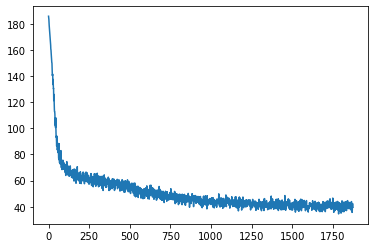

EPOCH 2:


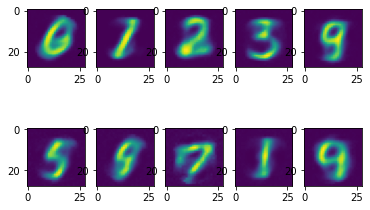

  batch 100 loss: 39.72919479370117 recons_loss: 33.87573867797852, regular_loss: 5.853455944061279
  batch 200 loss: 39.35823341369629 recons_loss: 33.55529287338257, regular_loss: 5.802940583229065
  batch 300 loss: 39.566038818359374 recons_loss: 33.599516735076904, regular_loss: 5.966522254943848
  batch 400 loss: 38.89593368530274 recons_loss: 32.9256227684021, regular_loss: 5.970311026573182
  batch 500 loss: 38.65424240112305 recons_loss: 32.69672348022461, regular_loss: 5.9575187730789185
  batch 600 loss: 38.976811180114744 recons_loss: 32.92307836532593, regular_loss: 6.053732857704163
  batch 700 loss: 38.596845703125 recons_loss: 32.68368619918823, regular_loss: 5.913159699440002
  batch 800 loss: 38.365716705322264 recons_loss: 32.3258429145813, regular_loss: 6.039874000549316
  batch 900 loss: 38.46823322296142 recons_loss: 32.432932205200196, regular_loss: 6.035300993919373
  batch 1000 loss: 38.314722328186036 recons_loss: 32.2601019859314, regular_loss: 6.0546202468872

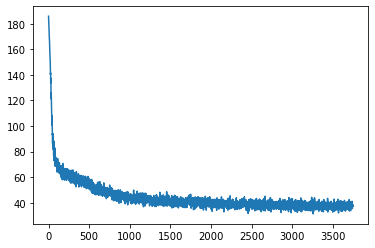

EPOCH 3:


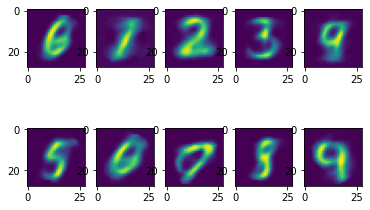

  batch 100 loss: 37.23931930541992 recons_loss: 30.96496332168579, regular_loss: 6.274355883598328
  batch 200 loss: 37.1524723815918 recons_loss: 30.98461368560791, regular_loss: 6.167858567237854
  batch 300 loss: 37.35214664459229 recons_loss: 31.06424736022949, regular_loss: 6.287899169921875
  batch 400 loss: 37.09743877410889 recons_loss: 30.81735782623291, regular_loss: 6.2800809049606325
  batch 500 loss: 37.358244762420654 recons_loss: 31.06931901931763, regular_loss: 6.288925766944885
  batch 600 loss: 37.11888542175293 recons_loss: 30.7391676902771, regular_loss: 6.3797176074981685
  batch 700 loss: 36.66723873138428 recons_loss: 30.27137748718262, regular_loss: 6.395861172676087
  batch 800 loss: 36.76917518615723 recons_loss: 30.411496391296385, regular_loss: 6.357678785324096
  batch 900 loss: 36.72442474365234 recons_loss: 30.315330772399903, regular_loss: 6.409093956947327
  batch 1000 loss: 36.47488815307617 recons_loss: 30.139898071289064, regular_loss: 6.33499009132

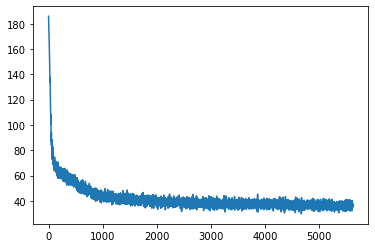

EPOCH 4:


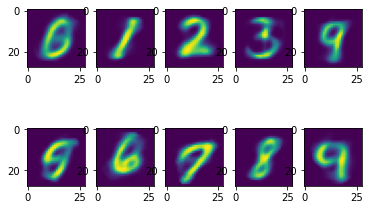

  batch 100 loss: 35.96131450653076 recons_loss: 29.369921970367432, regular_loss: 6.591392531394958
  batch 200 loss: 35.74704277038574 recons_loss: 29.191376399993896, regular_loss: 6.555666103363037
  batch 300 loss: 36.01430606842041 recons_loss: 29.50183015823364, regular_loss: 6.512475957870484
  batch 400 loss: 36.30385000228882 recons_loss: 29.795811805725098, regular_loss: 6.508038067817688
  batch 500 loss: 35.6533274269104 recons_loss: 29.08048999786377, regular_loss: 6.57283727645874
  batch 600 loss: 36.35912481307983 recons_loss: 29.716007938385008, regular_loss: 6.643116855621338
  batch 700 loss: 35.97306102752685 recons_loss: 29.324026927947997, regular_loss: 6.6490342330932615
  batch 800 loss: 36.08476760864258 recons_loss: 29.464471416473387, regular_loss: 6.6202962636947635
  batch 900 loss: 35.814726428985594 recons_loss: 29.206255588531494, regular_loss: 6.608470950126648
  batch 1000 loss: 35.818073234558106 recons_loss: 29.178270263671877, regular_loss: 6.63980

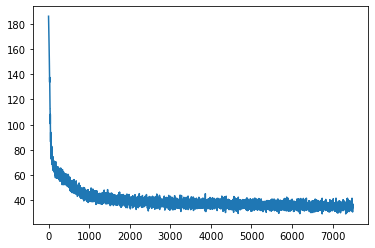

EPOCH 5:


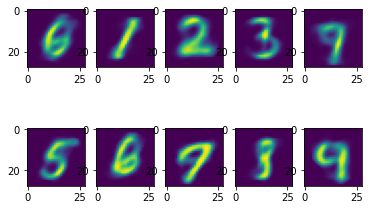

  batch 100 loss: 35.514267902374264 recons_loss: 28.757363166809082, regular_loss: 6.756904654502868
  batch 200 loss: 35.70253437042236 recons_loss: 28.945665378570556, regular_loss: 6.756868867874146
  batch 300 loss: 34.991359062194825 recons_loss: 28.247921714782716, regular_loss: 6.743437509536744
  batch 400 loss: 35.43606861114502 recons_loss: 28.69345365524292, regular_loss: 6.742614941596985
  batch 500 loss: 35.54919637680054 recons_loss: 28.713236255645754, regular_loss: 6.835960140228272
  batch 600 loss: 35.23914751052857 recons_loss: 28.44771827697754, regular_loss: 6.791429190635681
  batch 700 loss: 35.276162700653074 recons_loss: 28.498535804748535, regular_loss: 6.777626986503601
  batch 800 loss: 35.213467311859134 recons_loss: 28.362497749328615, regular_loss: 6.850969610214233
  batch 900 loss: 35.52243679046631 recons_loss: 28.739396457672118, regular_loss: 6.783040380477905
  batch 1000 loss: 35.080624389648435 recons_loss: 28.236322593688964, regular_loss: 6.84

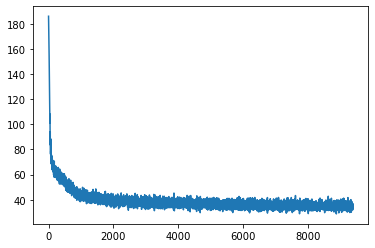

In [29]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5
best_vloss = 1_000_000

train_loss, val_loss = [], []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    with torch.no_grad():
        model.train(False)
        running_vloss = 0.0
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            batch_size = vinputs.shape[0]
            vmu, vsigma, vgenerated = model(vinputs)
            vloss = (((vinputs - vgenerated)**2).sum() + (-0.5 * torch.sum(1 + vsigma - vmu.pow(2) - vsigma.exp()))) / batch_size
            running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)

        samples = []
        for i in range(10):
            mu, sigma, generated = model(digit_samples[i].to(device))
            samples.append(generated.squeeze().detach().cpu().numpy())
    
        fig, ax = plt.subplots(2, 5)
        for i in range(10):
            ax[i//5][i%5].imshow(samples[i])
        plt.show()
        
    model.train(True)
    avg_loss, tracked_loss = train_one_epoch(epoch_number, writer)
    train_loss.extend(tracked_loss)
    
    
    plt.plot(train_loss)
    plt.show()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}'.format(timestamp)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1